# Tissue Clustering


In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData

In [2]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

In [3]:
data_path = 'C:/Users/mejas/Documents/BGI/datasets/stereoseq/SS200000135TL_D1_with_annotation.h5ad'
annotation_label = 'celltype_pred'
adata = sc.read(data_path)

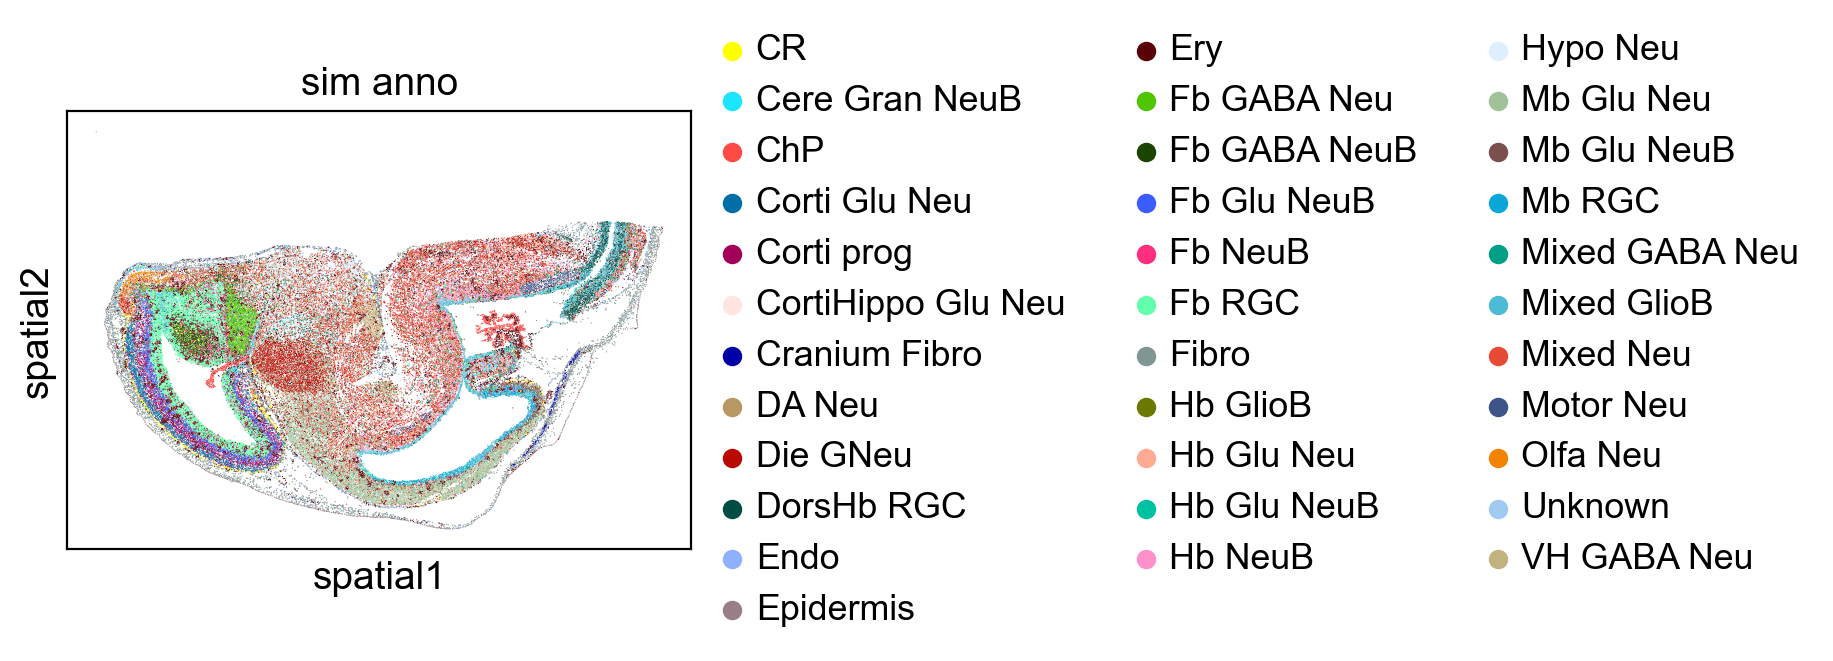

In [28]:
annotation_label = 'sim anno'
sc.pl.spatial(adata, color=annotation_label, spot_size=30)

# square bin

In [600]:
def tissue_cluster(adata1, use_col, bin_size = 200, moran_thres = 0.4):
    adata1.obs['Centroid_X'] = (adata1.obsm['spatial'][:,0]/bin_size).astype(int)
    adata1.obs['Centroid_Y'] = (adata1.obsm['spatial'][:,1]/bin_size).astype(int)
    adata1.obs['x_y'] = adata1.obs['Centroid_X'].astype(str) +'_'+adata1.obs['Centroid_Y'].astype(str)
    tmp = adata1.obs[['x_y', use_col]]
    templete_dic = {x:0 for x in tmp[use_col].cat.categories}
    ret = {}
    for x,y in tmp.groupby('x_y'):
        templete_dic = {x:0 for x in tmp[use_col].cat.categories}
        for z in y[use_col]:
            templete_dic[z]+=1
        ret[x] = templete_dic
    ret = pd.DataFrame(ret).T
    tissue = AnnData(ret)
    tissue.obsm['spatial'] = np.array([[x.split('_')[0], x.split('_')[1]] for x in ret.index]).astype(int)
    sc.pp.neighbors(tissue, use_rep='spatial')
    
    tissue.var['moransI'] = sc.metrics.morans_i(tissue)
    var_use = tissue.var.loc[tissue.var['moransI']>moran_thres].index
    tissue.raw = tissue
    tissue = tissue[:, var_use]
    
    #sc.pp.normalize_total(tissue, target_sum=1)
    sc.pp.neighbors(tissue, use_rep='X')
    sc.tl.leiden(tissue, 0.1)
    #sc.pl.spatial(tissue, spot_size=1, color='leiden')
    adata.obs['tissue_leiden']=list(tissue.obs.loc[adata.obs['x_y'], 'leiden'])
    return tissue

tissue = tissue_cluster(adata, annotation_label, bin_size = 200, moran_thres = -1)

C:\Users\mejas\AppData\Local\Temp/ipykernel_22244/1787278486.py:14: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tissue = AnnData(ret)


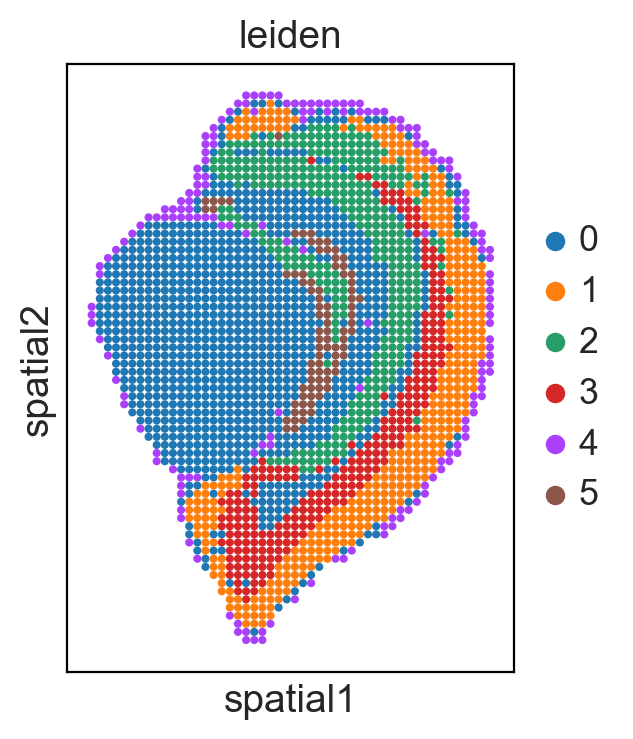

In [601]:
sc.pl.spatial(tissue, color='leiden', spot_size=1)

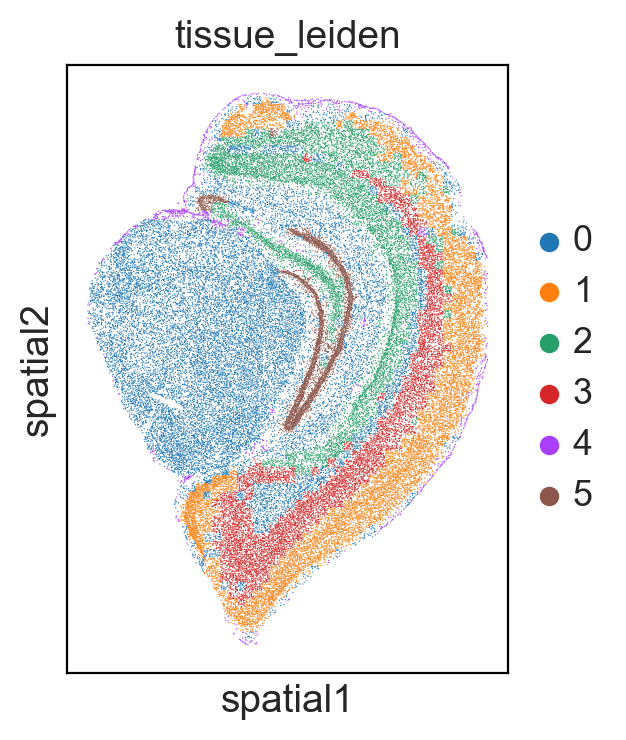

In [602]:
sc.pl.spatial(adata, color='tissue_leiden', spot_size=30)

# co-occurrence method

In [603]:
def density_calculator(stats, use_col, row, density_thred, l,r,u,d):
    left = row[1]['Centroid_X']+l*density_thred
    right = row[1]['Centroid_X']+r*density_thred
    up = row[1]['Centroid_Y']+u*density_thred
    down = row[1]['Centroid_Y']+d*density_thred
    #print(left, right, up, down)
    tmp = stats.loc[(stats['Centroid_X']<right)&(left<stats['Centroid_X'])&(stats['Centroid_Y']<up)&(down<stats['Centroid_Y'])]
    tmp = tmp.groupby(by=use_col).count()
    return list(tmp['Centroid_X'])
    

def tissue_cluster_cell_res(adata1, use_col, bin_size = 200, moran_thres = 0.0):
    adata1.obs['Centroid_X'] = (adata1.obsm['spatial'][:,0])
    adata1.obs['Centroid_Y'] = (adata1.obsm['spatial'][:,1])
    
    stats = adata1.obs[['Centroid_X', 'Centroid_Y', use_col]]
    stats[use_col].astype('category') 
    ret = []
    for row in stats.iterrows():
        tmp = density_calculator(stats,use_col, row, bin_size/2, -1,1,1,-1)
        ret.append(tmp)
        
    ret = pd.DataFrame(ret)
    ret.index = adata1.obs_names
    ret.columns = stats[use_col].cat.categories
    tissue = AnnData(ret)
    tissue.obsm['spatial'] = adata1.obsm['spatial']
    
    sc.pp.neighbors(tissue, use_rep='spatial')
    tissue.var['moransI'] = sc.metrics.morans_i(tissue)
    var_use = tissue.var.loc[tissue.var['moransI']>moran_thres].index
    tissue.raw = tissue
    tissue = tissue[:, var_use]
    sc.pp.neighbors(tissue, use_rep='X')
    sc.tl.leiden(tissue)
    #sc.pl.spatial(tissue, spot_size=1, color='leiden')
    #adata.obs['tissue_leiden']=list(tissue.obs.loc[adata.obs['x_y'], 'leiden'])
    return tissue

tissue = tissue_cluster_cell_res(adata, use_col=annotation_label, bin_size = 200, moran_thres = 0.0)

C:\Users\mejas\AppData\Local\Temp/ipykernel_22244/1131433871.py:26: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tissue = AnnData(ret)


<AxesSubplot:ylabel='Count'>

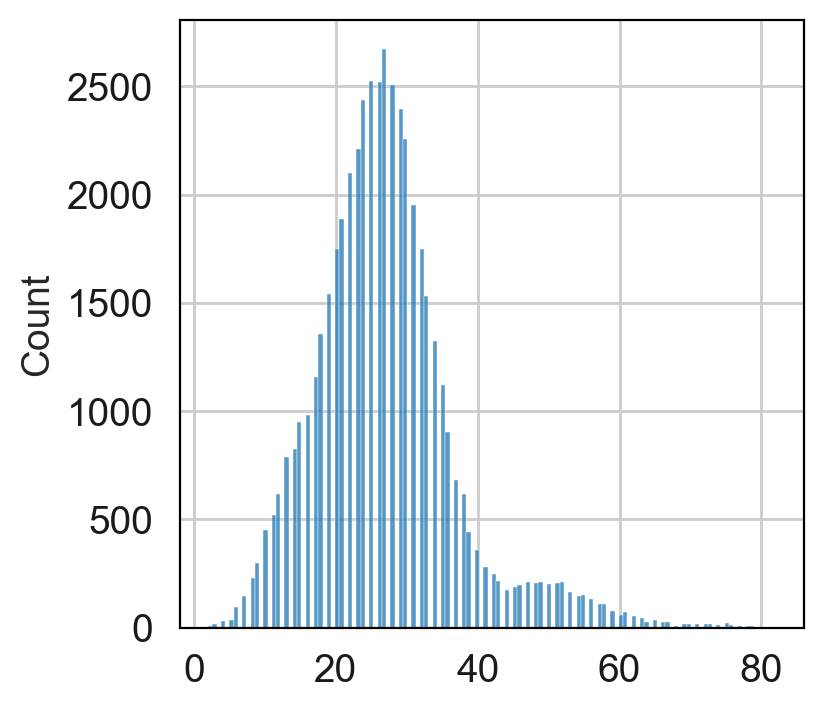

In [604]:
import seaborn as sns
sns.histplot(np.sum(tissue.X, axis=1))

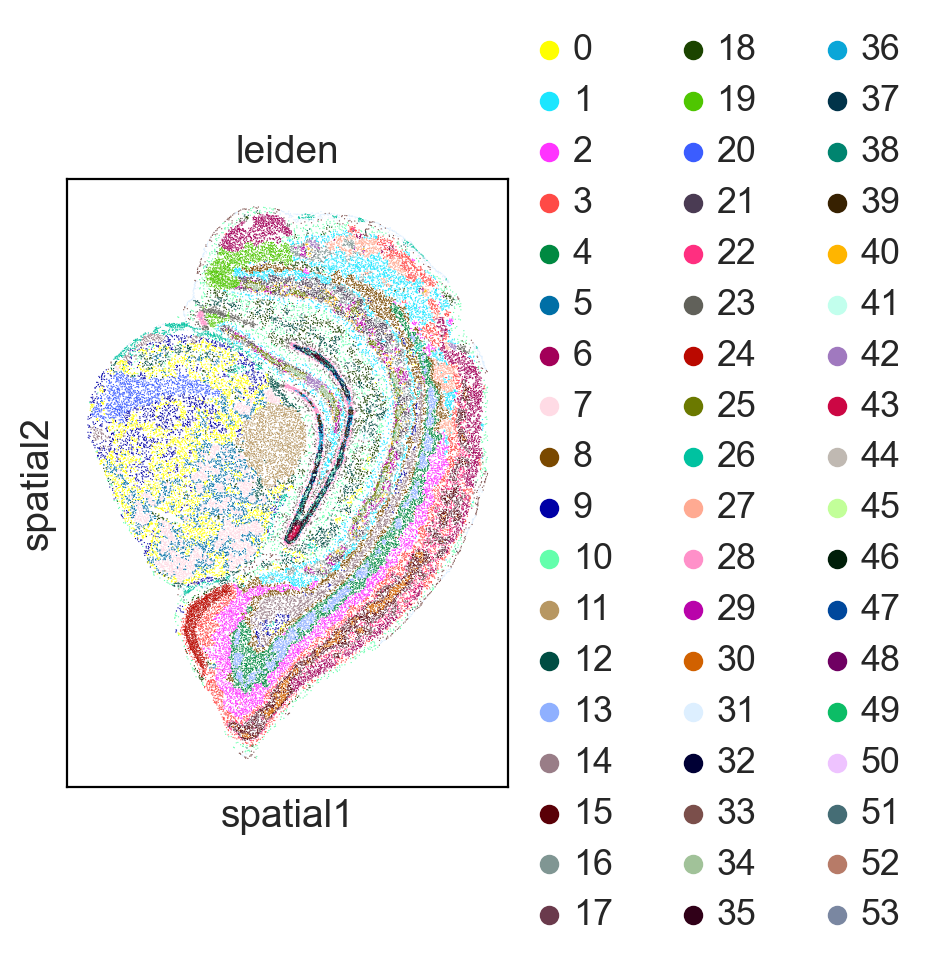

In [605]:
sc.pl.spatial(tissue, color='leiden', spot_size=30)

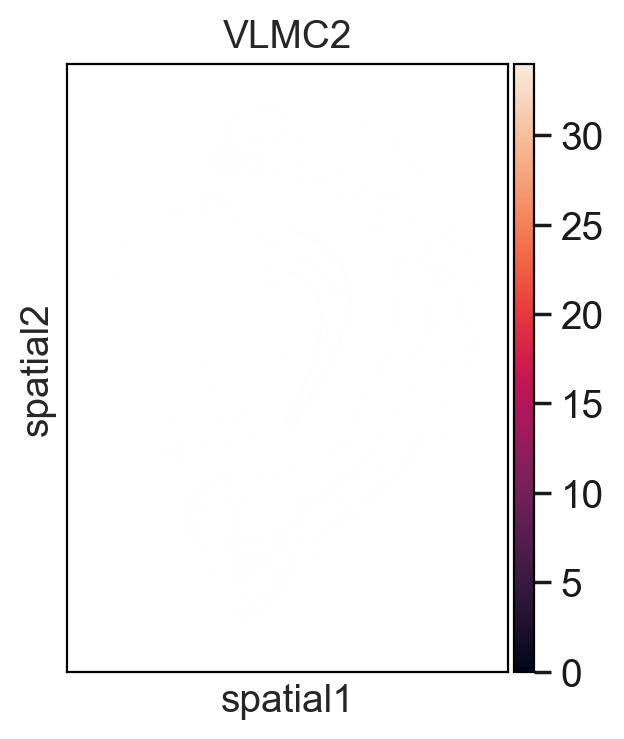

In [606]:
sc.pl.spatial(tissue, spot_size=1, color='VLMC2')

# phase position vote method

In [607]:
def tissue_cluster(adata1, use_col, bin_size = 150,  moran_thres = -1, bias_x = 0, bias_y = 0):
    adata1.obs['Centroid_X'] = ((adata1.obsm['spatial'][:,0]+bias_x)/bin_size).astype(int)
    adata1.obs['Centroid_Y'] = ((adata1.obsm['spatial'][:,1]+bias_y)/bin_size).astype(int)
    adata1.obs['x_y'] = adata1.obs['Centroid_X'].astype(str) +'_'+adata1.obs['Centroid_Y'].astype(str)
    tmp = adata1.obs[['x_y', use_col]]
    templete_dic = {x:0 for x in tmp[use_col].cat.categories}
    ret = {}
    for x,y in tmp.groupby('x_y'):
        templete_dic = {x:0 for x in tmp[use_col].cat.categories}
        for z in y[use_col]:
            templete_dic[z]+=1
        ret[x] = templete_dic
    ret = pd.DataFrame(ret).T
    tissue = AnnData(ret)
    tissue.obsm['spatial'] = np.array([[x.split('_')[0], x.split('_')[1]] for x in ret.index]).astype(int)
    sc.pp.neighbors(tissue, use_rep='spatial')

    tissue.var['moransI'] = sc.metrics.morans_i(tissue)
    var_use = tissue.var.loc[tissue.var['moransI']>moran_thres].index
    tissue.raw = tissue
    tissue = tissue[:, var_use]

    #sc.pp.normalize_total(tissue, target_sum=1)
    sc.pp.neighbors(tissue, use_rep='X')
    sc.tl.leiden(tissue)
    #sc.pl.spatial(tissue, spot_size=1, color='leiden')
    #adata1.obs['tissue_leiden']=list(tissue.obs.loc[adata1.obs['x_y'], 'leiden'])
    #return tissue
    return list(tissue.obs.loc[adata1.obs['x_y'], 'leiden'])


In [608]:
bias = [-50,0,50]
ret = []
for i in bias:
    for j in bias:
        tmp = tissue_cluster(adata, annotation_label, bias_x = i, bias_y =j)
        ret.append(tmp)

df = pd.DataFrame(ret).T

C:\Users\mejas\AppData\Local\Temp/ipykernel_22244/1458474573.py:14: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tissue = AnnData(ret)
C:\Users\mejas\AppData\Local\Temp/ipykernel_22244/1458474573.py:14: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tissue = AnnData(ret)
C:\Users\mejas\AppData\Local\Temp/ipykernel_22244/1458474573.py:14: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tissu

In [609]:
# df = pd.read_csv('./tissue_cluster_vote_result.csv', index_col=0).T

In [610]:
df

0   1   2   3   4   5   6   7   8
0      14  12  18  19  16  11  20  16  17
1      14   9  15  19  12  15  20  16  17
2      14  14  16  19  12  15  20  10  21
3      14  14  16  19  12  15  20  10  21
4       7   9  15  17  16  11   9  16  17
...    ..  ..  ..  ..  ..  ..  ..  ..  ..
49916  17  12  21  13  16  11  20  16  17
49917   9   9  15  13  16  11  11  16  13
49918  17   9  15  13  16  11  20  16  13
49919  14  12  21  19  16  15  20  16  17
49920  17   9  15  13  16  11  20  16  13

[49921 rows x 9 columns]

In [611]:
def compare_cluster(cluster1, cluster2):
    #n1 = cluster1.nunique()
    #n2 = cluster2.nunique()
    #if n1 > n2:
    #    cluster1, cluster2 = cluster2, cluster1 # keep cluster1 has less clusters
    df_tmp = pd.DataFrame({'c1':cluster1, 'c2':cluster2})
    ret = {}
    for i,j in df_tmp.groupby('c2'):
        ret[i]=j.groupby('c1').count()['c2'].idxmax()
    return [ret[x] for x in cluster2]



In [612]:
center_col = df.nunique().idxmin()
ret = []
for col in df:
    ret.append(compare_cluster(df[center_col], df[col]))
ret = pd.DataFrame(ret).T

In [613]:
labels = []
for row in ret.iterrows():
    tmp = list(row[1])
    labels.append(max(tmp, key=tmp.count))
    

In [614]:
adata.obs['tmp'] = labels

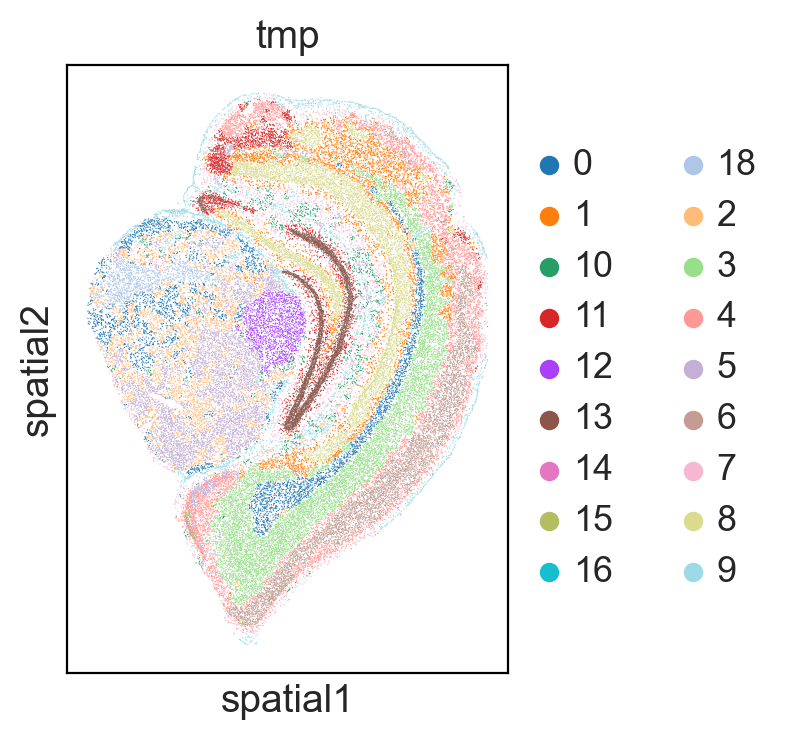

In [615]:
adata.obs['tmp'] = adata.obs['tmp'].astype('category')
sc.pl.spatial(adata, color='tmp', spot_size=30)

# Sliding window

In [8]:
def tissue_cluster(adata1, use_col, bin_size = 150,  moran_thres = -1, sliding_step = None, resolution=0.2):

    # bin size needs to be a multiple of sliding step
    sliding_step = (bin_size/int((bin_size/sliding_step))) if sliding_step!=None else bin_size
    bin_slide_ratio = int(bin_size/sliding_step)

    # create centroids for each sliding step of windows
    adata1.obs['Centroid_X'] = ((adata1.obsm['spatial'][:,0])/sliding_step).astype(int)
    adata1.obs['Centroid_Y'] = ((adata1.obsm['spatial'][:,1])/sliding_step).astype(int)
    # need to understand borders and padding
    # subwindows belonging to borders will not have a complete cell count
    x_max = adata1.obs['Centroid_X'].max()
    y_max = adata1.obs['Centroid_Y'].max()
    x_min = adata1.obs['Centroid_X'].min()
    y_min = adata1.obs['Centroid_Y'].min()

    adata1.obs['x_y'] = adata1.obs['Centroid_X'].astype(str) +'_'+adata1.obs['Centroid_Y'].astype(str)
    tmp = adata1.obs[['x_y', use_col]]
    templete_dic = {ct:0 for ct in tmp[use_col].cat.categories}
    ret = {}
    # calculate features for each subwindow
    for sw_ind, sw_data in tmp.groupby('x_y'):
        templete_dic = {ct:0 for ct in tmp[use_col].cat.categories}
        for cell in sw_data[use_col]:
            templete_dic[cell]+=1
        ret[sw_ind] = templete_dic
    # merge features by windows
    feature_matrix = {}
    for subwindow in ret.keys():
        # index of window is in the top left corner of the whole window
        feature_matrix[subwindow] = {}
        x_curr = int(subwindow.split("_")[0])
        y_curr = int(subwindow.split("_")[1])
        # count the number of subwindows participating in full window feature vec
        num_subw = 0

        for slide_x in range(0, np.min([bin_slide_ratio, x_max-x_curr+1])):
            for slide_y in range(0, np.min([bin_slide_ratio, y_max-y_curr+1])):  # starts from 1 since values with coordinates (0,0) are already written by initializing with ret[subwindow]
                if (f'{x_curr + slide_x}_{y_curr + slide_y}') in ret.keys():
                    num_subw += 1
                    feature_matrix[subwindow] = {k: 
                                                feature_matrix[subwindow].get(k, 0) + ret[f'{x_curr + slide_x}_{y_curr + slide_y}'].get(k, 0)
                                                for k in set(feature_matrix[subwindow]).union(ret[f'{x_curr + slide_x}_{y_curr + slide_y}'])}
        # # scale the feature values by the number of summed subwindows that form it (it could be useful as feature vector normalization)
        # feature_matrix[subwindow] = {k:feature_matrix[subwindow][k]/num_subw for k in feature_matrix[subwindow].keys()}

    feature_matrix = pd.DataFrame(feature_matrix).T
    tissue = AnnData(feature_matrix)
    tissue.obsm['spatial'] = np.array([[x.split('_')[0], x.split('_')[1]] for x in feature_matrix.index]).astype(int)
    sc.pp.neighbors(tissue, use_rep='spatial')

    tissue.var['moransI'] = sc.metrics.morans_i(tissue)
    var_use = tissue.var.loc[tissue.var['moransI']>moran_thres].index
    tissue.raw = tissue
    tissue = tissue[:, var_use]

    # sc.pp.normalize_total(tissue, target_sum=1)
    sc.pp.neighbors(tissue, use_rep='X')
    sc.tl.leiden(tissue, resolution=resolution)

    # max voting on cluster labels
    # init the new obs column
    tissue.obs['leiden_refined'] = list('x' for x in range(len(tissue.obs.index)))
    for x_curr, y_curr in tissue.obsm['spatial']:
        # index of subwindow is in the top left corner of the whole window
        subwindow_labels = {}
        for slide_x in range(0, np.min([bin_slide_ratio, x_curr - x_min + 1])):
            for slide_y in range(0, np.min([bin_slide_ratio, y_curr - y_min + 1])):
                # check if location exist (spatial area is not complete)
                if (f'{x_curr - slide_x}_{y_curr - slide_y}') in tissue.obs.index:
                    new_value = tissue.obs.loc[f'{x_curr - slide_x}_{y_curr - slide_y}', 'leiden']
                    subwindow_labels[new_value] = subwindow_labels[new_value] + 1 if new_value in subwindow_labels.keys() else 1
        
        # max vote
        # max vote should be saved in a new obs column so that it does not have diagonal effect on
        # other labels during refinment
        tissue.obs['leiden_refined'][f'{x_curr}_{y_curr}'] = max(subwindow_labels, key=subwindow_labels.get)


    #sc.pl.spatial(tissue, spot_size=1, color='leiden')
    adata1.obs['tissue_sliding_leiden'] = list(tissue.obs.loc[adata1.obs['x_y'], 'leiden_refined'])

    return tissue

In [617]:
adata

AnnData object with n_obs × n_vars = 49921 × 22404
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'psuedo_class', 'celltype_pred', 'morpho_featureID', 'leiden', 'Centroid_X', 'Centroid_Y', 'x_y', 'tissue_leiden', 'tmp'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'Exp', 'Pos', 'celltype_pred_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'psuedo_classes', 'tissue_leiden_colors', 'tmp_colors'
    obsm: 'X_pca', 'cell_seg_feature', 'psuedo_label', 'spatial'
    obsp: 'Combined_connectivities', 'Exp_connectivities', 'Exp_distances', 'Im_connectivities', 'Im_distances', 'Pos_connectivities', 'Pos_distances', 'connectivities'

In [9]:
# define if only cell types with more than 100 cells are used for cell communities extraction
more_than_100 = False
if more_than_100:

    cell_over_100 = []
    for cell_tp in adata.obs[annotation_label].cat.categories:
        cell_num = sum(adata.obs[annotation_label]==cell_tp)
        if cell_num > 100:
            cell_over_100.append(cell_tp)

    adata = adata[adata.obs[annotation_label].isin(cell_over_100),:]

In [10]:
tissue = tissue_cluster(adata1=adata, use_col=annotation_label, bin_size=150, moran_thres=-1, sliding_step=50, resolution=0.1)

C:\Users\mejas\AppData\Local\Temp/ipykernel_28596/1681325082.py:48: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tissue = AnnData(feature_matrix)
C:\Users\mejas\AppData\Local\Temp/ipykernel_28596/1681325082.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tissue.obs['leiden_refined'][f'{x_curr}_{y_curr}'] = max(subwindow_labels, key=subwindow_labels.get)


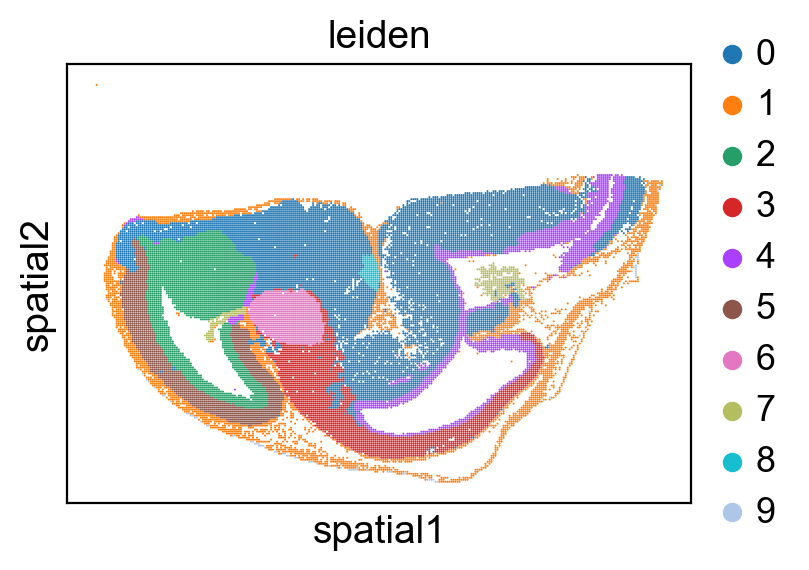

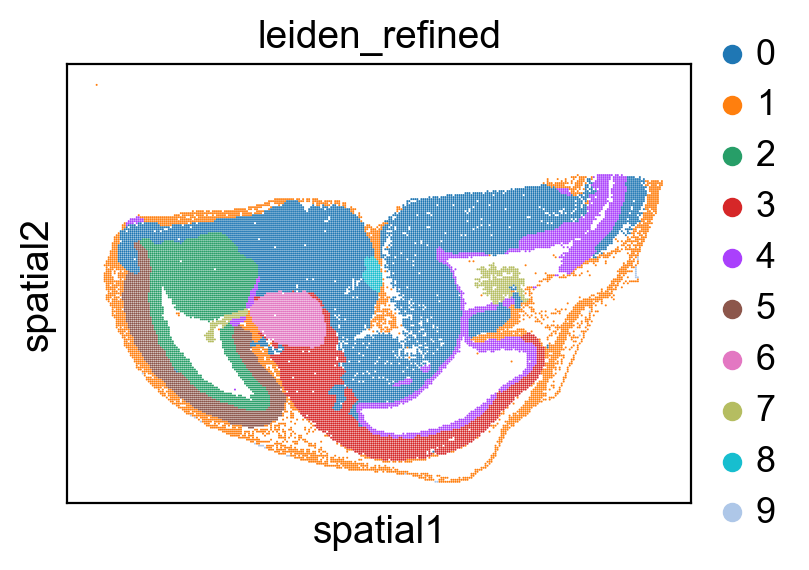

In [11]:
# plot initial clustering for each window
sc.pl.spatial(tissue, color='leiden', spot_size=1)
# plot clustering after majority voting for each subwindow
sc.pl.spatial(tissue, color='leiden_refined', spot_size=1)

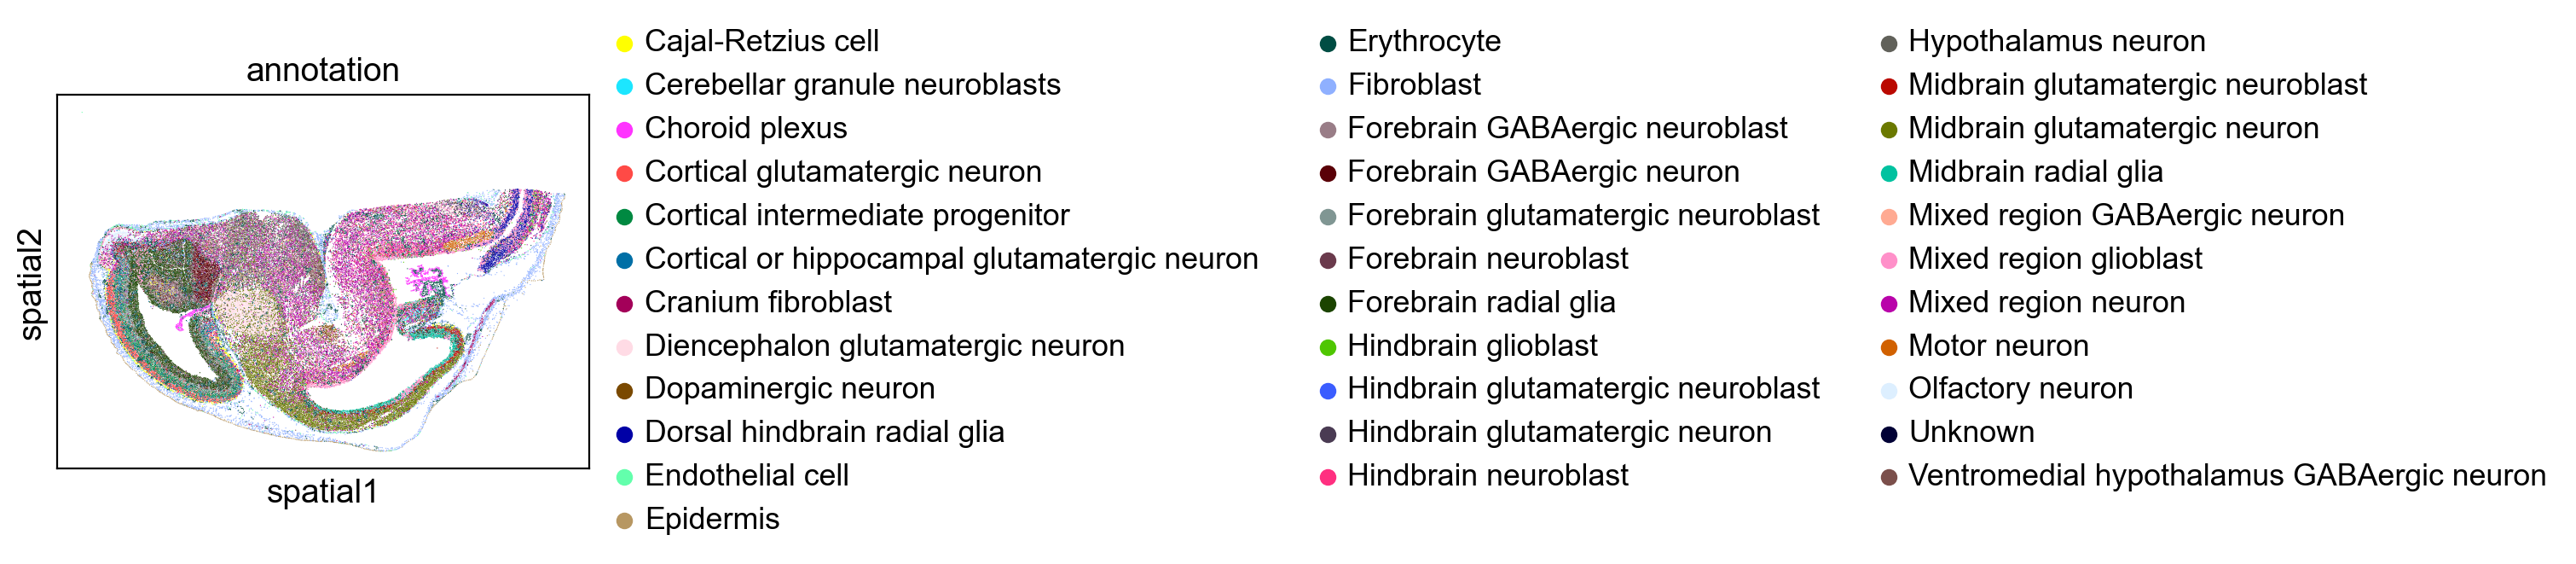

In [13]:
sc.pl.spatial(adata, color=annotation_label, spot_size=30)

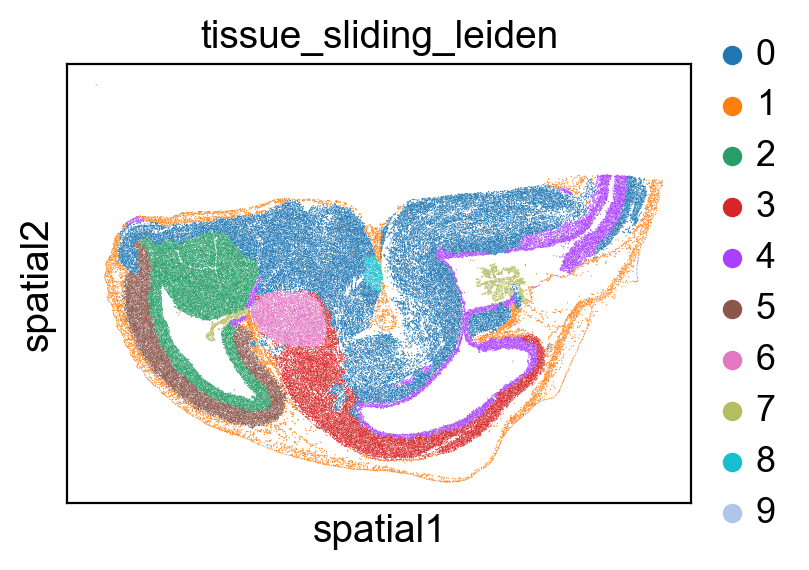

In [12]:
# plot final clustering in cell resolution
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.spatial(adata, color='tissue_sliding_leiden', spot_size=30)

## Cell community statistics

In [622]:
# extract information on leiden clustering labels and cell types to create cell communities statistics
clustering_labels = 'tissue_sliding_leiden'
cell_types_col = annotation_label
cell_types_communities = adata.obs[[clustering_labels, cell_types_col]]

stats_table = {}
# calculate cell type mixtures for every cluster
for label, cluster_data in cell_types_communities.groupby(clustering_labels):
    cell_type_dict = {ct:0 for ct in cell_types_communities[cell_types_col].cat.categories}
    for cell in cluster_data[cell_types_col]:
        cell_type_dict[cell]+=1
    total_cluster_cells = sum(cell_type_dict.values())
    # stats_table[label] = {ct:int(cell_type_dict[ct]/total_cluster_cells*100) for ct in cell_type_dict.keys()}
    stats_table[label] = {ct:cell_type_dict[ct] for ct in cell_type_dict.keys()}

    stats_table[label]['total_counts'] = int(sum(cell_type_dict.values()))



stats = pd.DataFrame(stats_table).T
# stats.index.name='clusters'
stats.columns.name="cell types"

# add final row with total counts per cell types
cell_type_counts = {ct:[int(sum(stats[ct].values))] for ct in cell_types_communities[cell_types_col].cat.categories}
stats = pd.concat([stats, pd.DataFrame(cell_type_counts, index=['total_cells'])])






In [623]:
stats

ABC  ACNT1  ACTE1  ACTE2  COP2  DEGLU1  DEGLU5  DGGRC2  MBDOP2  \
0              0   4382     15      0     4       6     121      41      16   
1              0   1220      2     28     0       0       0     450       0   
2              0   1094      0      0     0       0       0     200       0   
3              0    949      1      0     2       0       0       5       0   
4              1   1478     13      3     0       0       5     345       0   
5              0   3007      0      0     0       1     107      28       1   
6              0     99      0      0     0       0       0      22       0   
7              0    120      0      0     0       0       0    2935       0   
8             12    197      5      0     0       1       0       7       0   
9              0    531      0      0     0     610       1       9       0   
10             0     50      0      1     0       0       0       7       0   
11             0    202      0      0     0       0       1       0     504   
12             0      0      0      0     0       0       0       0       0   
13             0      0      0      0     0       0       0       0       0   
14             2      0      0      0     0       0       0       0       0   
15             0      0      0      0     0       0       0       0       0   
16             1      0      0      0     0       0       0       0       0   
17             0      0      0      0     0       0       0       0       0   
total_cells   16  13329     36     32     6     618     235    4049     521   

             MEGLU1  ...  TEGLU4  TEGLU7  TEGLU8  TEINH1  TEINH17  TEINH18  \
0                11  ...       0       0       3     438        6        9   
1                 0  ...     213     551    4918       2       28       17   
2                 0  ...      93       8     136       3        6        3   
3                 0  ...     343       0     121       1        1       27   
4                 0  ...       3       6      19       9        3        0   
5                 5  ...       0       0       2     214        2        6   
6                 0  ...       1       0       0       0        0        0   
7                 0  ...       0       0       0       0        2        0   
8                 0  ...       1       0       2       0        1        0   
9                 0  ...       0       0       0       1        0        0   
10                0  ...       2       2    1505       0        5        7   
11                0  ...       0       0       0      25        0        0   
12                0  ...       0       0       0       0        0        0   
13                0  ...       0       0       0       0        0        0   
14                0  ...       0       0       0       0        0        0   
15                0  ...       0       0       0       0        0        0   
16                0  ...       0       0       0       0        0        0   
17                0  ...       0       0       0       0        0        0   
total_cells      16  ...     656     567    6706     693       54       69   

             TEINH19  VECV  VLMC2  total_counts  
0                476     1    679        9288.0  
1                466    29     46        8559.0  
2               1123     4     50        6581.0  
3                580     5     35        6971.0  
4                237     9    431        2860.0  
5                134     0     38        3927.0  
6                109     0      2        3094.0  
7                 12     0      1        3108.0  
8                 19     0   1139        1438.0  
9                  1     0    107        1349.0  
10                24     1      0        1615.0  
11                31     1     10         944.0  
12                 0     0      0          67.0  
13                 0     0      0          59.0  
14                 0     0     18          20.0  
15                 0     0      0           7.0  
16                 0 

In [624]:
# divide each row with total sum of cells per cluster
for i in range(len(stats.index.values[:-1])):
    stats.iloc[i, :-1] = (100 * stats.iloc[i, :-1] / stats.iloc[i, -1]).astype(int)

In [625]:
stats

ABC  ACNT1  ACTE1  ACTE2  COP2  DEGLU1  DEGLU5  DGGRC2  MBDOP2  \
0              0     47      0      0     0       0       1       0       0   
1              0     14      0      0     0       0       0       5       0   
2              0     16      0      0     0       0       0       3       0   
3              0     13      0      0     0       0       0       0       0   
4              0     51      0      0     0       0       0      12       0   
5              0     76      0      0     0       0       2       0       0   
6              0      3      0      0     0       0       0       0       0   
7              0      3      0      0     0       0       0      94       0   
8              0     13      0      0     0       0       0       0       0   
9              0     39      0      0     0      45       0       0       0   
10             0      3      0      0     0       0       0       0       0   
11             0     21      0      0     0       0       0       0      53   
12             0      0      0      0     0       0       0       0       0   
13             0      0      0      0     0       0       0       0       0   
14            10      0      0      0     0       0       0       0       0   
15             0      0      0      0     0       0       0       0       0   
16             5      0      0      0     0       0       0       0       0   
17             0      0      0      0     0       0       0       0       0   
total_cells   16  13329     36     32     6     618     235    4049     521   

             MEGLU1  ...  TEGLU4  TEGLU7  TEGLU8  TEINH1  TEINH17  TEINH18  \
0                 0  ...       0       0       0       4        0        0   
1                 0  ...       2       6      57       0        0        0   
2                 0  ...       1       0       2       0        0        0   
3                 0  ...       4       0       1       0        0        0   
4                 0  ...       0       0       0       0        0        0   
5                 0  ...       0       0       0       5        0        0   
6                 0  ...       0       0       0       0        0        0   
7                 0  ...       0       0       0       0        0        0   
8                 0  ...       0       0       0       0        0        0   
9                 0  ...       0       0       0       0        0        0   
10                0  ...       0       0      93       0        0        0   
11                0  ...       0       0       0       2        0        0   
12                0  ...       0       0       0       0        0        0   
13                0  ...       0       0       0       0        0        0   
14                0  ...       0       0       0       0        0        0   
15                0  ...       0       0       0       0        0        0   
16                0  ...       0       0       0       0        0        0   
17                0  ...       0       0       0       0        0        0   
total_cells      16  ...     656     567    6706     693       54       69   

             TEINH19  VECV  VLMC2  total_counts  
0                  5     0      7        9288.0  
1                  5     0      0        8559.0  
2                 17     0      0        6581.0  
3                  8     0      0        6971.0  
4                  8     0     15        2860.0  
5                  3     0      0        3927.0  
6                  3     0      0        3094.0  
7                  0     0      0        3108.0  
8                  1     0     79        1438.0  
9                  0     0      7        1349.0  
10                 1     0      0        1615.0  
11                 3     0      1         944.0  
12                 0     0      0          67.0  
13                 0     0      0          59.0  
14                 0     0     90          20.0  
15                 0     0      0           7.0  
16                 0 

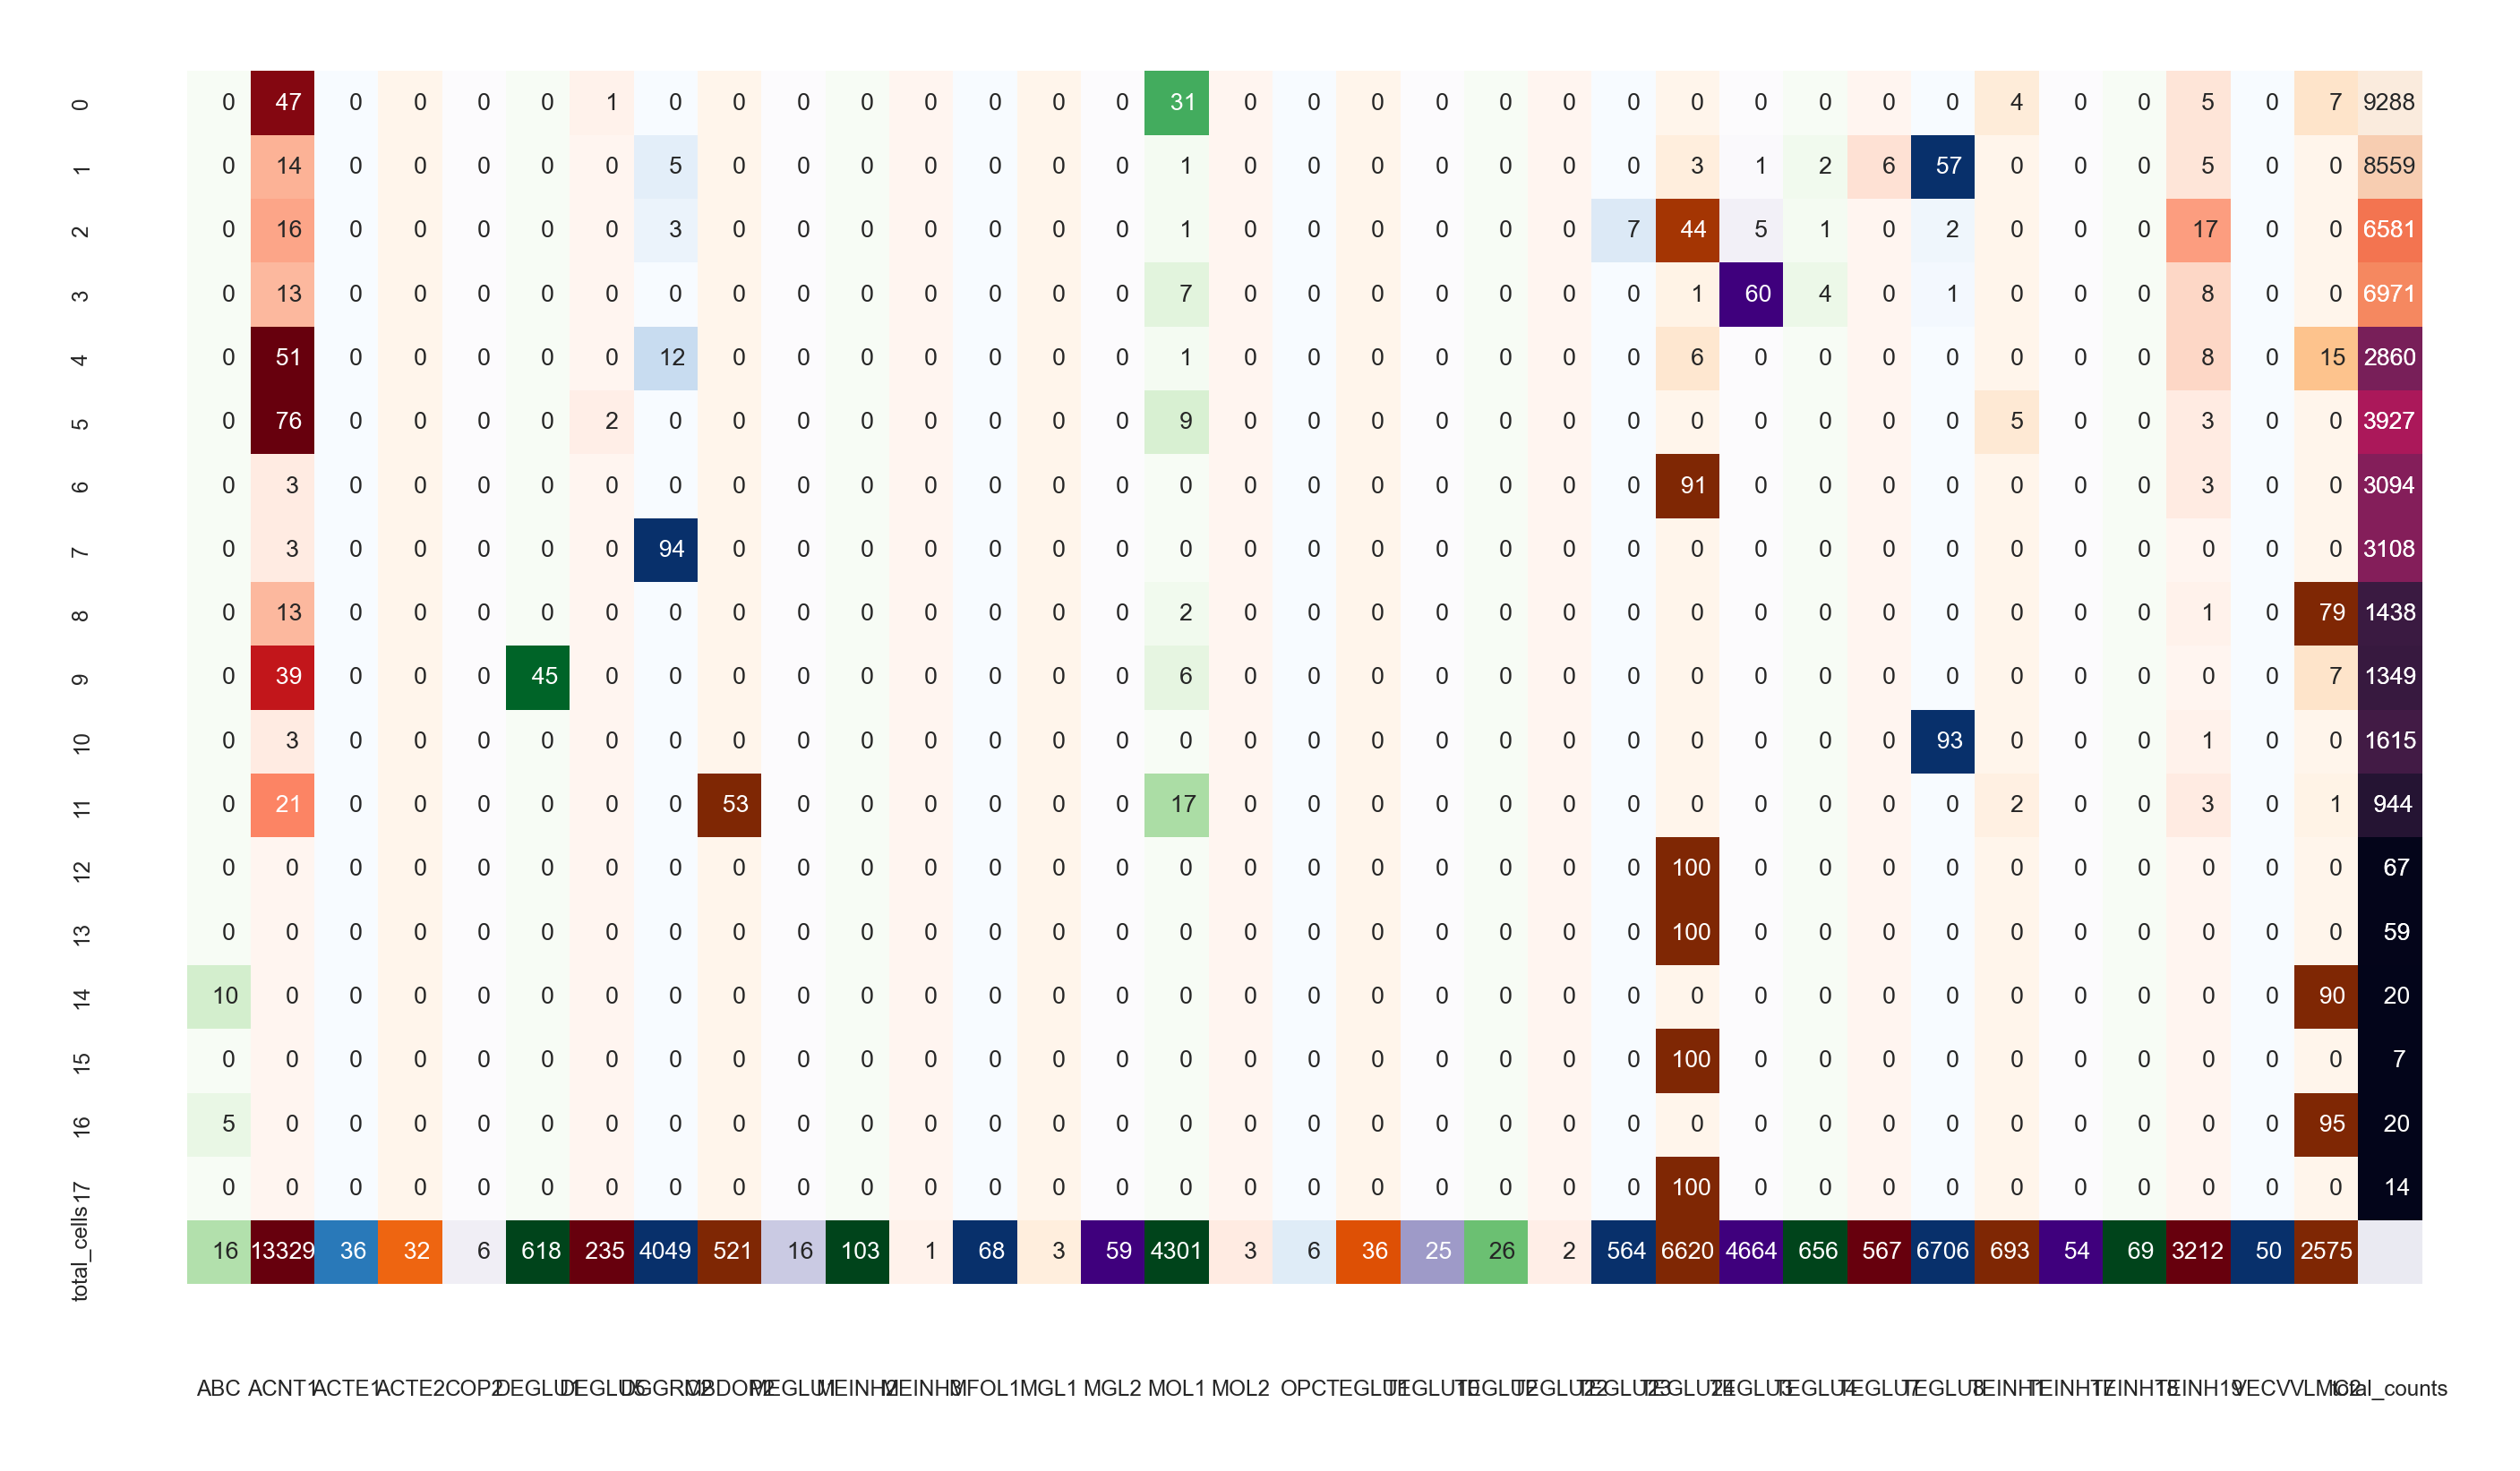

In [626]:
from matplotlib import pyplot as plt
from itertools import cycle
sc.settings.set_figure_params(dpi=400, facecolor='white')
sns.set(font_scale=0.2)

ncols = len(stats.columns) # we want to separately print the total_counts column
fig, axes = plt.subplots(ncols=ncols)

# no space between columns
fig.subplots_adjust(wspace=0)

# put colormaps of your choice in a list:
cmap_cycle = cycle(['Greens', 'Reds', 'Blues', 'Oranges', 'Purples'])

annotation_keywords = {ct:0 for ct in cell_types_communities[cell_types_col].cat.categories}
x_labels = [x for x in cell_types_communities[cell_types_col].cat.categories]

for i, ax in enumerate(axes):
    sns.heatmap(pd.DataFrame(stats.iloc[:, i]), vmin=0.0, vmax=50, linewidths=0, linecolor=None, annot=True, cbar=False, ax=ax, cmap=cmap_cycle.__next__(),fmt='4.0f', xticklabels=True, yticklabels=True if i==0 else False, square=True)
# final column should have the sum of all cells per cluster
sns.heatmap(pd.DataFrame(stats.iloc[:, -1]), annot=True, linewidths=0, linecolor=None, cbar=False, cmap=None, ax=ax, fmt='4.0f', xticklabels=True, yticklabels=False, square=True)

plt.show()

### main cell types per cluster

### cluster 2, 9, 11, 13

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


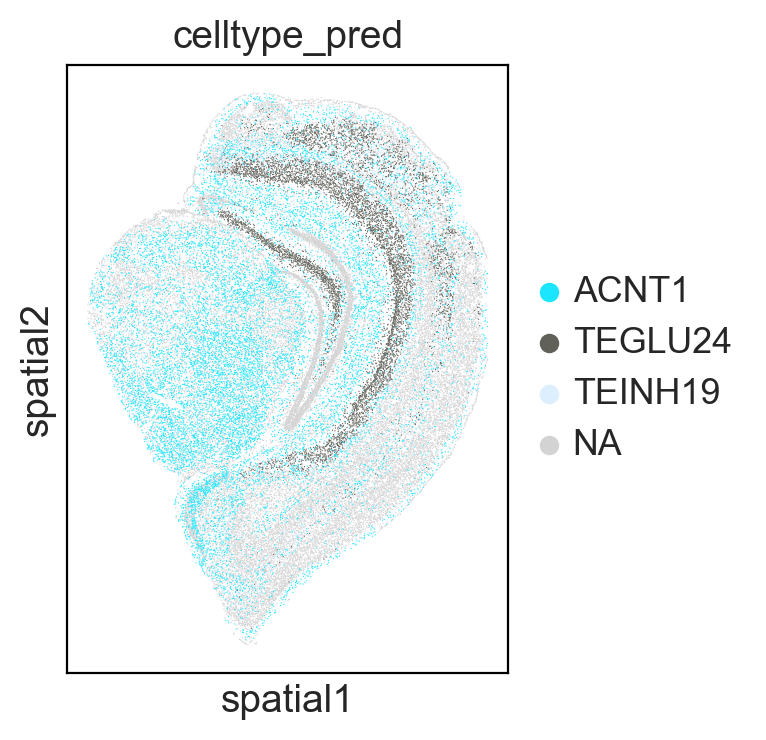

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


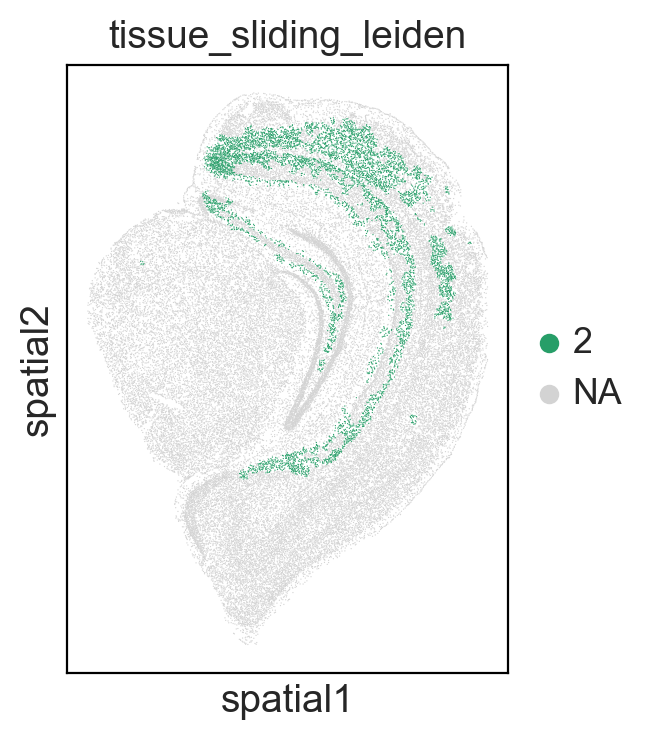

In [627]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
# cluster2 = adata[adata.obs[annotation_label] == stats.columns[1]].concatenate(adata[adata.obs[annotation_label] == stats.columns[23]]).concatenate(adata[adata.obs[annotation_label] == stats.columns[31]])
sc.pl.spatial(adata, groups=[stats.columns[1], stats.columns[23], stats.columns[31]], color=annotation_label, spot_size=30)
sc.pl.spatial(adata, groups=['2'], color='tissue_sliding_leiden', spot_size=30)

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


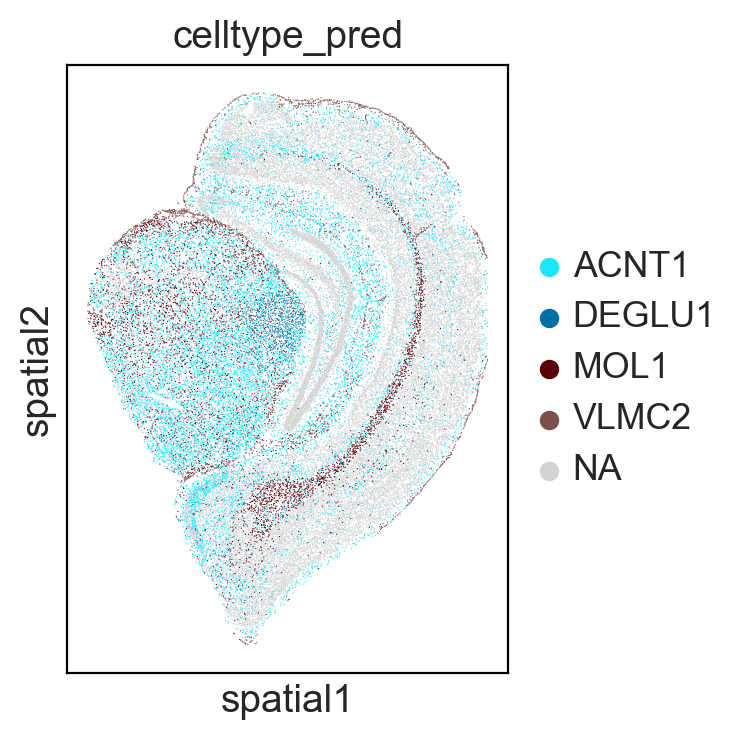

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


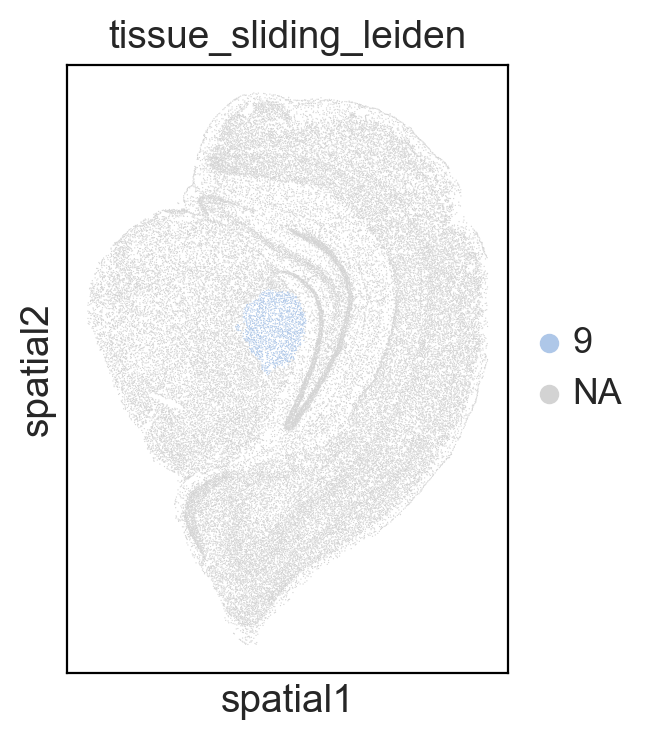

In [628]:
# plot cells of cluster 9 in original colors
sc.settings.set_figure_params(dpi=100, facecolor='white')
# cluster9 = adata[adata.obs[annotation_label] == stats.columns[1]].concatenate(adata[adata.obs[annotation_label] == stats.columns[5]]).concatenate(adata[adata.obs[annotation_label] == stats.columns[15]]).concatenate(adata[adata.obs[annotation_label] == stats.columns[33]])
sc.pl.spatial(adata, groups=[stats.columns[1], stats.columns[5], stats.columns[15], stats.columns[33]], color=annotation_label, spot_size=30)
sc.pl.spatial(adata, groups=['9'], color='tissue_sliding_leiden', spot_size=30)

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


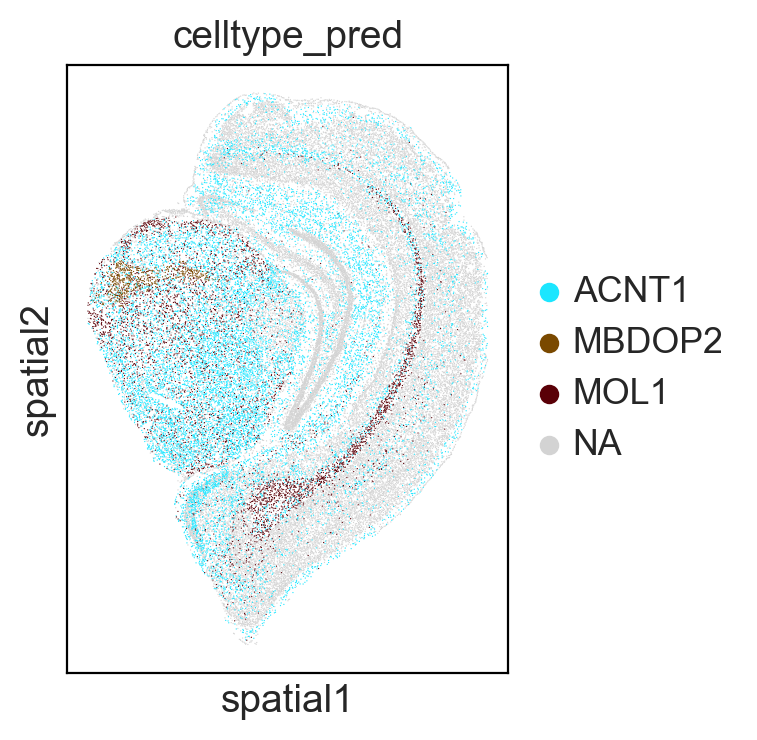

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


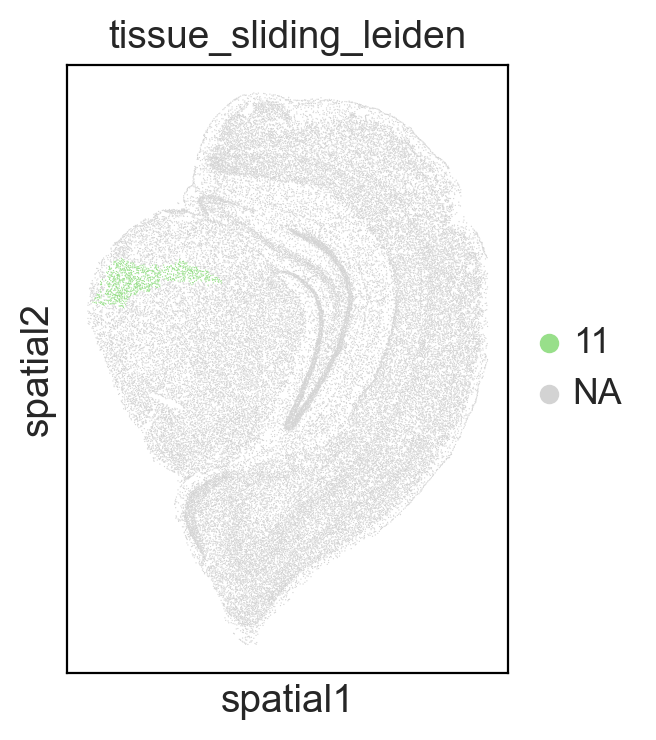

In [629]:
# plot cells of cluster 11 in original colors
sc.settings.set_figure_params(dpi=100, facecolor='white')
# cluster11 = adata[adata.obs[annotation_label] == stats.columns[1]].concatenate(adata[adata.obs[annotation_label] == stats.columns[8]]).concatenate(adata[adata.obs[annotation_label] == stats.columns[15]])
sc.pl.spatial(adata, groups=[stats.columns[1], stats.columns[8], stats.columns[15]], color=annotation_label, spot_size=30)
sc.pl.spatial(adata, groups=['11'], color='tissue_sliding_leiden', spot_size=30)

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


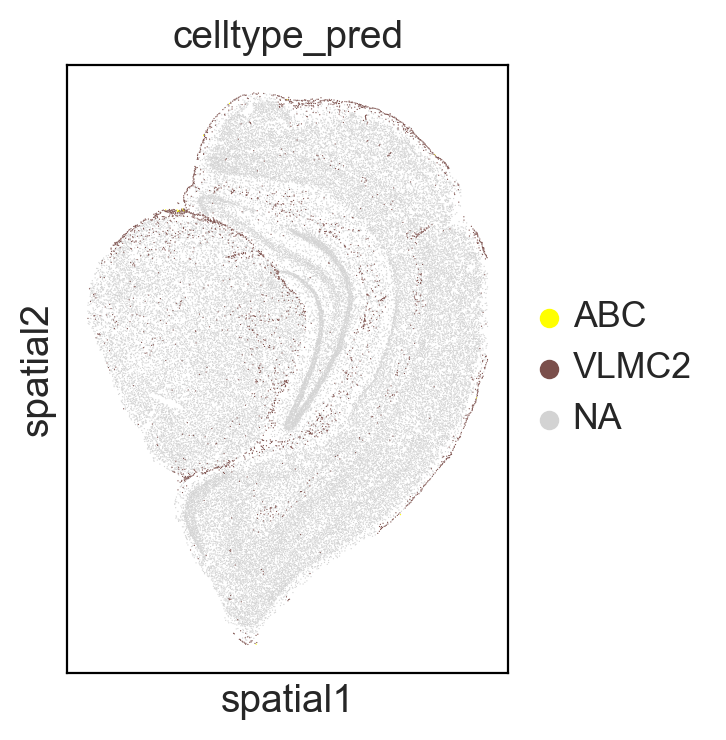

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


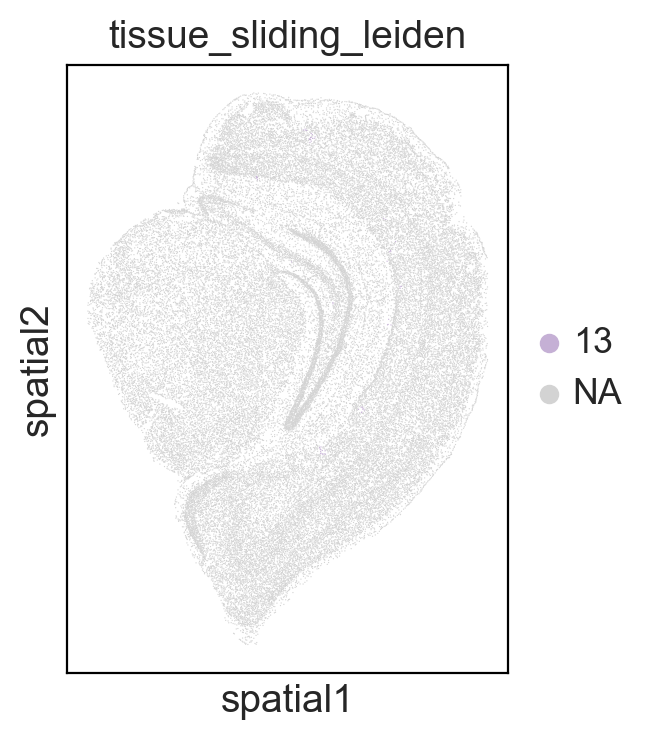

In [630]:
# plot cells of cluster 13 in original colors
sc.settings.set_figure_params(dpi=100, facecolor='white')
# cluster13 = adata[adata.obs[annotation_label] == stats.columns[0]].concatenate(adata[adata.obs[annotation_label] == stats.columns[33]])
sc.pl.spatial(adata, groups=[stats.columns[0], stats.columns[33]], color=annotation_label, spot_size=30)
sc.pl.spatial(adata, groups=['13'], color='tissue_sliding_leiden', spot_size=30)